# Spiral Tip detection via the Location-centric method

This code is layed out to calculate the spiral tips of excitable media via the loaction-centric method and plot the solution per frame.

Requires: the solution of an excitable media model with two files. 
- The first data file "_u" should give the field of the activating conponment  
- and the second file "_v" should give the field of the inhibiting componment.  <br />
Both files should have the shape (total nr. of time steps or frames, domain length in x-direction, domain length in y-direction). 

Delivers: 
- phases (calculated via time-delay, analytical signal or two varibles)
- spiral tips (detected via location-centric method)
- plots of excitation field and spiral tips for every time step (animation has to be done seperatly)*
- plots of phases and spiral tips for every time step (animation has to be done seperatly)*
- animation of the spiral tips on their own

$*$ Warning: Will create a number of PNGs in your files equal to the amount of time steps  in the given data ($=:t_{len}$) and potentially use large amounts of your working memory!!! 

In [1]:
# I have read the warning and understand that if I run the entirety of this code, 
# it will create t_len images for 'spiral tips on the excitation field' and another
# t_len images for 'spiral- tips on phases' in my files. Enter 'yes' to confirm.

confirmation = "no, don't create those specific plots" #'yes'

In [2]:
# Import functions and packages from libary
from projectlib2 import *

### For which parameters we created solutions in the FitzHugh-Nagumo model
|Nr. of spirals | Time of excitation $t_{excit}$ | Nr. of frames | Time of last frame $t_{end}$ | [data name].nyp  
|----------|-------------  |--------|--------|-----------------------|
|1         | 175           | 200    | 400       | FHN\_u                
|2         | 150 in refrac.| 200    | 400       |                       
|          | 150 in vun.   | 200    | 400       |                       
|          | 150 in repol. | 200    | 400       |                       
|          | 175           | 200    | 400       | FHN\_2spirals\_200    
|4         | 175           | 50     | 600       | FHN\_4spirals\_50\_u  
|          | 175           | 50     | 600       | FHN\_4spirals\_100\_u 
|          | 175           | 200    | 600       | FHN\_4spirals\_200\_u 
|          | 175           | 400    | 600       | FHN\_4spirals\_400\_u 



In [3]:
# enter everything in this field
U = np.load("FHN_4spirals_u_50.npy") # t_len maps with NxN pixels
V = np.load("FHN_4spirals_v_50.npy") # t_len maps with NxN pixels
t_end = 600     # time of the last frame

# choose which phase detection method and varibles to use  
tau = 1        # time shift in phase calculation, vary for somewhat better results
method = 1      # method used to calculate the phases with 1: time-delay, 
                # 2: analytical signal, 3: two varibles

## Defining Functions

In [4]:
# automaticaly calculated: ----------------------------------------------------
t_len = len(U[:,0,0])           # amount of time steps
N     = len(U[0,0,:])           # amount of pixels along one axis
output_steps = len(U[:,0,0])    # amount of time steps
                                
dt = t_end/output_steps         # time steps between frames
frame_len = output_steps/t_end  # "how much" of a frame one dt takes up
print(f"time step between frames {dt}", "\n",)

time step between frames 12.0 



### Mean Potential

In [5]:
#average potential for all time and pixels 
def mean_potential(U):
    '''average potential over time & pixels '''
    t_len = len(U[:,0,0])     # amount of time steps
    N = len(U[0,0,:])         # amount of pixels along one axis
    
    summe = 0
    for i in range(N):        # for every coloum         
        for j in range(N):    # and every pixel in that coloum
            for n in range(t_len):
                summe += U[n,i,j] # add value
    return summe /(t_len*N*N) 

# incorecct! mean potential over time per pixel
def mean_potential_false(U):
    ''' for every pixel (i,j) on an NxN map 
        calculate average potential over time '''
    N = len(U[0,0,:])
    
    U_mean = np.zeros((N,N))   
    for i in range(N):                
        for j in range(N):            
            U_mean[i][j] = sum(U[:,i,j])/(N*N)  
    return U_mean

### Method 1: Phase calculations with timeshift $\tau$ (as done in paper)
$
\begin{align}
    \theta(t) = \textrm{arctan}\left(U(i,j,t+\tau) - U_{mean}, U(i,j,t) - U_{mean} \right) 
\end{align}
$

In [6]:
def phase_detection(U, V):
    ''' phases of the potential via time-delay '''
    U_mean = mean_potential(U)
    #V_mean = mean_potential(V)
    
    phase = np.zeros(np.shape(U)) 
    for i in range(N):                
        for j in range(N):  
            for n in range(tau, t_len):
                phase[n,i,j] = np.arctan2( (U[n, i, j] - U_mean), (U[n-tau, i, j]   - U_mean))
    return phase 

### Method 2: Analytical phase calculation 
(code slightly changed from Torben slightly, so shape of the outputed phases is (t_len, N, N) )

In [7]:
def single_phase_timeseries(single_u):     # returns the time series of the phase of the analytic signal for one specific pixel, given the u-timeseries in the pixel
    u_tilde = single_u - np.mean(single_u) # just difference from mean
    z = u_tilde + 1j * hilbert(u_tilde)    # z is the analytic signal, composed using the Hilbert trafo
    phi = np.arctan2(z.imag,z.real)        # phase of the analytic signal
    return phi

def phase_detection2(U, V):
    ''' phases of the potential via the analytical signal'''
    N = len(U[0,0,:])                      # amount of pixels along one axis
    phases = np.array([[single_phase_timeseries(U[:,j,i]) for i in range(N)] for j in range(N)])
    return phases.transpose(2,0,1)

### Method 3: Phase calculated via 2 varibles
$
\begin{align}
    \theta(t) = \textrm{arctan}\left(U(i,j,t+\tau) - U_{mean}, V(i,j,t) - V_{mean} \right) 
\end{align}
$

In [8]:
def phase_detection3(U, V):
    ''' phases of the potential via two varibles'''
    U_mean = mean_potential(U)
    V_mean = mean_potential(V)
    
    phase = np.zeros(np.shape(U)) 
    for i in range(N):                
        for j in range(N):  
            for n in range(tau, t_len):
                phase[n,i,j] = np.arctan2( (U[n, i, j] - U_mean), (V[n, i, j]   - V_mean))
    return phase 

### Spiral Tips detection with Location Centric
If the phase difference $(\Delta \theta)_{m} = \theta_{m} - \theta_{m-1}$ is smaller than $- \pi$ for a given pixel at time step $m$, then that pixel is detected as a spiral tip. 

In [9]:
def tip_detection(U, V, method=1):
    ''' find spiral tips in potential
    for given excited pixels U, refractory pixels V
    with U & V being n N*N matrixes 
    where n is the total number of inputed frames '''
    if method == 1:
        phases = phase_detection(U, V)
    elif method == 2:
        phases = phase_detection2(U, V)
    elif method == 3:
        phases = phase_detection3(U, V)
    else:
        print(f"{method} isn't a phase detection method.")
        
    tip = np.zeros(np.shape(U)) 
    for i in range(N):                
        for j in range(N):  
             for n in range(t_len-1):
                if (phases[n+1,i,j] - phases[n,i,j] < -np.pi):
                    tip[n,i,j] = 1
                else:
                    tip[n,i,j] = 0
    return tip, phases

## Detecting Spiral Tips

In [10]:
tip, phase = tip_detection(U, V, method)

In [11]:
#check in which frame spiral tips were detected and how many   <br />
print("frame : amount of spiral tips")
for n in range(t_len):
    amount = 0
    for i in range(N):                
        for j in range(N):  
            if tip[n,i,j] == 1:
                amount += 1
    if (amount != 0):
        print(f"{n}: {amount}")         

frame : amount of spiral tips
15: 52
16: 4
17: 4
19: 4
24: 4
25: 4
27: 4
38: 4
43: 4
45: 4


## Ploting

### Only the spiral tip

plot frame 15 at time 180.0


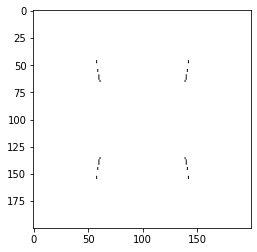

In [12]:
# Plot just tips
def plot_tip(n):    
    return plt.imshow(tip[n].reshape(N, N),  cmap="Greys")

# test plot:
time  = 175                           
frame = int(np.ceil(frame_len*time))  
plot_tip(frame)
print(f"plot frame {frame} at time {dt*frame}")

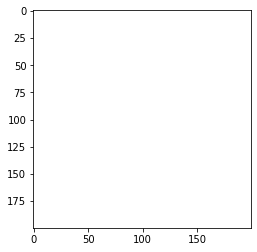

In [13]:
# Animation of the spiral tips for all time
frame_setting = t_len
interval_setting=10000/frame_setting
ani1 = animation.FuncAnimation(plt.gcf(), plot_tip,frames=frame_setting, interval=interval_setting, blit=False,repeat_delay=100)
HTML(ani1.to_html5_video())

### Tips on potential

In [14]:
# Define function to scatter plot spiral tips on top of the phases map
def plot_tip_and_real(n):
    M = tip[n].reshape(N, N)
    
    for i in range(N):
        for j in range(N):
            if (M[i][j] == 1):
                plt.scatter(j, i, s=10, facecolors='w', edgecolors='none', alpha=1) # spiral tips as white dots
    plt.imshow(U[n].reshape(N, N), vmin=-0.2, vmax=1.01, cmap="magma")

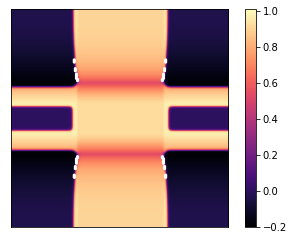

plot frame 15 at time 180.0


In [15]:
# Plot one specific frame (tips on exhitation field)
time  = 175                           # time at which frame should be plotted          
frame = int(np.ceil(frame_len*time))  # frame wich should be plotted 

fig, ax=plt.subplots()
ax.set_yticks([])
ax.set_xticks([])
plot_tip_and_real(frame)
plt.colorbar()
plt.show()

print(f"plot frame {frame} at time {dt*frame}")

In [16]:
%%time
# Plots and save every frame localy 
# A video has to be created manually with a different software

if (confirmation == 'yes'):  #check for confrimation to save t_len images
    amount_of_frames = t_len
else:
    print("Error: Confirmation not given. Please read and confirm statement in cell 2, "
           "then 'amount_of_frames' will automatically be defined")
    
for n in range(amount_of_frames):
    fig, ax=plt.subplots(dpi=100)
    ax.set_yticks([])
    ax.set_xticks([])
    plt.title(f"t={dt*n}", size = 10)
    plot_tip_and_real(n)
    plt.colorbar()
    #plt.show()
    plt.savefig(f"excitation_{n}.png") # be warned this creates t_len images in your files
    #plt.clf() 
    plt.close(fig)
    if n==t_len:
        break

Error: Confirmation not given. Please read and confirm statement in cell 2, then 'amount_of_frames' will automatically be defined


NameError: name 'amount_of_frames' is not defined

### Plot tips on phase

In [17]:
# Define function to scatter plot spiral tips on top of the phases map
def plot_tip_and_phase(n):
    M = tip[n].reshape(N, N)
    for i in range(N):
        for j in range(N):
            if (M[i][j] == 1):
                plt.scatter(j, i, s=10, facecolors='k', edgecolors='none', alpha=1) # spiral tips as black dots
    plt.imshow(U[n].reshape(N, N), vmin=0, vmax=1, cmap="coolwarm")

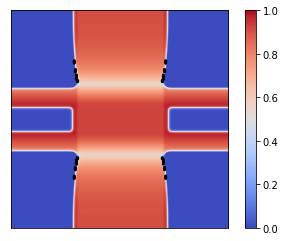

plot frame 15 at time 180.0


In [18]:
# Plot one specific frame (tips on exhitation field)
time  = 175                           # time at which frame should be plotted          
frame = int(np.ceil(frame_len*time))  # frame wich should be plotted 

fig, ax=plt.subplots()
ax.set_yticks([])
ax.set_xticks([])
plot_tip_and_phase(frame)
plt.colorbar()
plt.show()

print(f"plot frame {frame} at time {dt*frame}")

In [19]:
%%time
# Plots and save every frame localy 
# A video has to be created manually with a different software

if (confirmation == 'yes'):  #check for confrimation to save t_len images
    amount_of_frames = t_len
else:
    print("Error: Confirmation not given. Please read and confirm statement in cell 2, "
           "then 'amount_of_frames' will automatically be defined")
    
for n in range(amount_of_frames):
    fig, ax=plt.subplots(dpi=100)
    ax.set_yticks([])
    ax.set_xticks([])
    plt.title(f"t={dt*n}", size = 10)
    
    plot_tip_and_phase(n)
    
    plt.colorbar()
    #plt.show()
    plt.savefig(f"phase_{n}") # be warned this creates t_len images in your files
    plt.close(fig)
    #plt.clf() #why dosen't this work instead?
    if n==t_len:
        break

Error: Confirmation not given. Please read and confirm statement in cell 2, then 'amount_of_frames' will automatically be defined


NameError: name 'amount_of_frames' is not defined

### Notes on the animation for 'tips on exhitation  field' and also 'tips on phases' with animation.FuncAnimation:
- for large frame numbers and many detected spiral tips the animation of the scattering function may be very slow.
- additonally scatter plots are not removed for the next frame <br />
→ that is why these direct animations are no longer used

##### animation of tips on exitation field:
def plot_tip_and_real2(n):
    M = tip[n].reshape(N, N)
    for i in range(N):
        for j in range(N):
            if (M[i][j] == 1):
                plt.scatter(j, i, s=10, facecolors='none', edgecolors='w', alpha=0.25)#0.25 
    
    plt.imshow(U[n].reshape(N, N), vmin=-0.2, vmax=1.01, cmap="magma")

frame_setting = t_len
interval_setting=10000/frame_setting
ani1 = animation.FuncAnimation(plt.gcf(), plot_tip_and_real2, frames=frame_setting, interval=interval_setting, blit=False,repeat_delay=100)
HTML(ani1.to_html5_video())

##### animation of tips on phases: 
def plot_tip_and_phase2(n):
    M = tip[n].reshape(N, N)

    for i in range(N):
        for j in range(N):
            if (M[i][j] == 1):
                plt.scatter(j, i, s=5, facecolors='grey', edgecolors='k', alpha=0.25)
    
    plt.imshow(U[n].reshape(N, N), vmin=0, vmax=1, cmap="coolwarm")

frame_setting = t_len
interval_setting=10000/frame_setting
ani1 = animation.FuncAnimation(plt.gcf(), plot_tip_and_phase2, frames=frame_setting, interval=interval_setting, blit=False,repeat_delay=100)
HTML(ani1.to_html5_video())